In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

## Graph Mining Project Update Presentation: Anomaly Detection in Graphs

This is a document detailing the work I've done learning about anomaly and outlier detection in graphs.

## Recap

Anomaly detection is important in all sorts of problems:

- Financial Fraud Detection
- Network Security

There are several different methods to finding anomalies, each at different scopes of the graph. An outlier can be global, local, or community-scoped.

## What I've Worked On

In the past few weeks I've 

## Scope Pivot

due to a lack of available outlier labeled datasets for financial transaction graphs

## Data

This data is synthetic data created by me following a power law and long tail distribution similar to a real-world graph, very similar to how synthetic data is created in other papers [\[1\]](#ref1). Each edge has 4 numeric attributes following a pareto distribution. We are going to attempt to find which edges seem anomalous (like a fraudulent charge, or an illegitimate network package distribution).

In [2]:
data_root = "../data/"

In [3]:
filepath = os.path.join(data_root, "synthetic/", "graph-10000.pickle")
with open(filepath, 'rb') as f:
    G = pickle.load(f)
outlier_n = int(G.order() / 100)
G.order(), G.size()

(10000, 19996)

## Models
### Global Outlier Detection

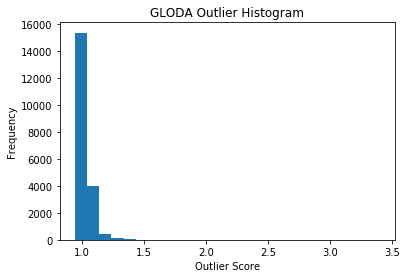

Wall time: 1.98 s


In [4]:
%%time
D = np.zeros((G.size(), 4))
edge_data = nx.get_edge_attributes(G, "D")
edges = list(G.edges())
for i, e in enumerate(edges):
    D[i] = edge_data[e]
knn = 20
clf = LocalOutlierFactor(n_neighbors=knn)
clf.fit(D)
GLODA_worst_offenders = (-clf.negative_outlier_factor_).argsort()[-outlier_n:]
GLODA_outliers = set(edges[i] for i in GLODA_worst_offenders)
plt.hist(-clf.negative_outlier_factor_, bins=25)
plt.title("GLODA Outlier Histogram")
plt.xlabel("Outlier Score")
plt.ylabel("Frequency")
plt.show()

Our other strategies require the context of the graph structure to create inferences.

#### Line Graph

The graph algorithms discussed here are node-focused. However, our data reads in an edgelist of transactions. To create meaningful inferences, we will run our anomaly detection algorithms on the induced [line graph](https://mathworld.wolfram.com/LineGraph.html) of the data. Now, each edge in the original graph is a node in the induced graph, and edges in the induced graph show edges that shared a node in the original graph.

In [5]:
edge_G = nx.line_graph(G)
attr = dict.fromkeys(edge_G.nodes())
for source, target in edge_G.nodes():
    attr[(source, target)] = G[source][target]
nx.set_node_attributes(edge_G, attr)

### Direct Neighbor Outlier Detection

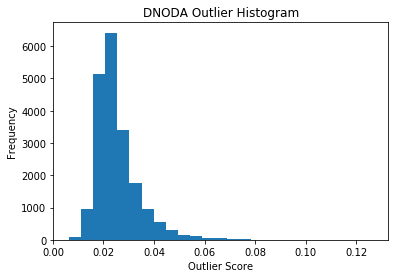

Wall time: 15.4 s


In [6]:
%%time
DNODA_distances = np.zeros(edge_G.order())
node_data = nx.get_node_attributes(edge_G, "D")
nodes = edges
for i, v in enumerate(nodes):
    p0 = node_data[v]
    dist = 0
    for u in edge_G.neighbors(v):
        p1 = node_data[u]
        dist += np.sqrt(np.sum(np.square(p0 - p1)))
    DNODA_distances[i] = dist / edge_G.degree(v)
DNODA_worst_offenders = np.argsort(DNODA_distances)[-outlier_n:]
DNODA_outliers = set(nodes[i] for i in DNODA_worst_offenders)
plt.hist(DNODA_distances, bins=25)
plt.title("DNODA Outlier Histogram")
plt.xlabel("Outlier Score")
plt.ylabel("Frequency")
plt.show()

### Community Outlier Detection

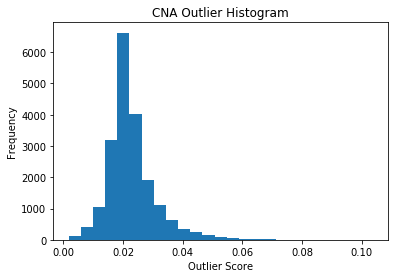

Wall time: 1min 6s


In [7]:
%%time
CNA_distances = np.zeros(edge_G.order())
communities = [list(c) for c in nx.algorithms.community.label_propagation_communities(edge_G)]
for c in communities:
    for v in c:
        p0 = node_data[v]
        dist = 0
        for u in c:
            p1 = node_data[u]
            dist += np.sqrt(np.sum(np.square(p0 - p1)))
        i = nodes.index(v)
        CNA_distances[i] = dist / len(c)
CNA_worst_offenders = np.argsort(CNA_distances)[-outlier_n:]
CNA_outliers = set(nodes[i] for i in CNA_worst_offenders)
plt.hist(CNA_distances, bins=25)
plt.title("CNA Outlier Histogram")
plt.xlabel("Outlier Score")
plt.ylabel("Frequency")
plt.show()

In [8]:
all_algo_outliers = GLODA_outliers.intersection(DNODA_outliers).intersection(CNA_outliers)
print(all_algo_outliers)
len(all_algo_outliers), len(GLODA_outliers)

{(642, 1181), (8552, 8813), (3701, 6908), (60, 2204), (1660, 6101), (52, 1725), (5, 116), (135, 2373), (592, 1145), (1779, 4960), (557, 6815), (247, 409), (7694, 9035), (451, 1327), (4520, 5508), (37, 6954), (122, 353), (79, 2425), (2174, 2324), (559, 8574), (119, 6941), (1901, 4548), (4727, 5699), (82, 848), (3, 4521), (25, 558), (2678, 3529), (6901, 9127), (1014, 1280), (491, 6279), (5887, 6717), (99, 5059), (9, 4655), (6518, 9307), (14, 370), (1680, 4247), (4027, 8080), (5, 436), (4992, 5765), (288, 3551), (812, 7946), (3373, 6698), (723, 1960), (158, 300), (3144, 6503), (350, 606), (1079, 2235), (2594, 3982), (37, 2248)}


(49, 100)

It seems like while the algorithms execute differently, they do contain some similar results. The algorithms identify a similar group of outliers, although the outlier ranking might be in a slightly different order. Let's see if there are outliers that are unique to each of these algorithms:

In [9]:
exclusive_GLODA_outliers = GLODA_outliers.difference(DNODA_outliers.union(CNA_outliers))
exclusive_DNODA_outliers = DNODA_outliers.difference(GLODA_outliers.union(CNA_outliers))
exclusive_CNA_outliers = CNA_outliers.difference(DNODA_outliers.union(GLODA_outliers))
print("Exclusive GLODA determined outliers:")
print(exclusive_GLODA_outliers)
print()
print("Exclusive DNODA determined outliers:")
print(exclusive_DNODA_outliers)
print()
print("Exclusive CNA determined outliers:")
print(exclusive_CNA_outliers)

Exclusive GLODA determined outliers:
{(1987, 4185), (489, 5851), (1568, 8399), (505, 2853), (83, 1476), (4491, 6518), (458, 5170), (550, 7351), (1009, 7993), (2829, 7507), (1403, 3329), (27, 9947), (611, 1315), (713, 9045), (5394, 9905), (41, 1399), (1687, 4681), (956, 2208), (226, 4248), (3101, 3428), (434, 4126), (128, 2589), (35, 57), (5315, 5494), (286, 2698), (4851, 5589), (870, 9523), (28, 8370), (1886, 5370), (2432, 3669), (2189, 5257), (345, 6686), (78, 7294), (7593, 8340), (175, 3646), (756, 2911), (3338, 4818), (3216, 7963), (2189, 6418), (279, 1999), (1774, 3182), (2551, 7931), (1064, 1083)}

Exclusive DNODA determined outliers:
{(2827, 5898), (2334, 8129), (616, 3905), (2397, 3573), (1120, 5895), (1649, 3199), (4581, 4942), (1318, 4672), (1487, 6728), (378, 807), (5823, 9822), (4991, 8533), (121, 6275), (6027, 7187), (1013, 4723)}

Exclusive CNA determined outliers:
{(14, 273), (5667, 8688), (742, 3655), (12, 442), (14, 2674), (417, 8772), (66, 4119), (833, 5704), (79, 8424

- The exclusive GLODA outliers are outliers which without the context of the graph structure seem to look rather anomalous, but their outlier status seem to be explained by the graph context, as their neighbors or community have similar attributes.
- The DNODA outliers are only found to be anomalous in the context of its direct neighbors, but it is not considered particularly anomalous in the context of the community it is in nor the entire graph.
- The CNA outliers are only anomalous in the context of the community, but not necesarily in the context of its direct neighbors or 

### Hybrid Model

In a large real-world graph, there will most likely be anomalous nodes from the direct neighbor, community, and global scope. To identify outliers at each of these scopes, let's take an average of each algorithm's "outlier score" per node (low meaning average, high meaning anomalous) and see which nodes jump out at us:

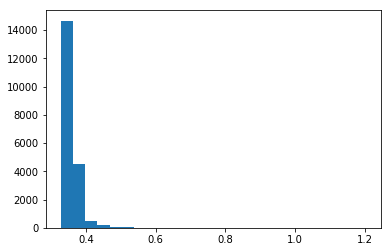

{(1568, 8399), (1660, 6101), (135, 2373), (2829, 7507), (5307, 5486), (119, 6941), (5394, 9905), (226, 4248), (35, 57), (14, 370), (286, 2698), (4851, 5589), (723, 1960), (158, 300), (175, 3646), (350, 606), (1079, 2235), (37, 2248), (83, 1476), (4491, 6518), (458, 5170), (0, 8753), (52, 1725), (5, 116), (550, 7351), (1009, 7993), (1779, 4960), (4520, 5508), (247, 409), (37, 6954), (27, 9947), (1162, 8804), (559, 8574), (1901, 4548), (8996, 9777), (82, 848), (4727, 5699), (3101, 3428), (5531, 6145), (5315, 5494), (6518, 9307), (4992, 5765), (812, 7946), (3373, 6698), (870, 9523), (279, 1999), (2551, 7931), (2189, 5257), (2594, 3982), (642, 1181), (1, 3), (1987, 4185), (8552, 8813), (505, 2853), (3701, 6908), (60, 2204), (557, 6815), (451, 1327), (79, 2425), (2174, 2324), (3, 4521), (5246, 7391), (25, 558), (6901, 9127), (128, 2589), (9, 4655), (78, 7294), (3338, 4818), (3144, 6503), (1064, 1083), (489, 5851), (592, 1145), (7694, 9035), (1403, 3329), (611, 1315), (122, 353), (713, 9045)

In [10]:
hybrid_model = ((-clf.negative_outlier_factor_) + DNODA_distances + CNA_distances) / 3
hybrid_outliers = set(nodes[i] for i in hybrid_model.argsort()[-outlier_n:])
plt.hist(hybrid_model, bins=25)
plt.show()
print(hybrid_outliers)

## What's Next

## References

1. <a id="ref1">http://snap.stanford.edu/class/cs224w-2015/projects_2015/Anomaly_Detection_in_Graphs.pdf</a>